In [15]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import tensorflow as tf
import pandas as pd
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
import datetime
import joblib
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# %matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
cols = ['user','item','rating','timestamp']
data = pd.read_csv('ml-100k/u.data', sep='\t',names=cols)

In [3]:
data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
data.head()

,user,item,rating,timestamp,datetime
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16


In [5]:
data.sort_values(by=['user', 'timestamp'], inplace=True)

In [6]:
data.index = range(len(data))

In [7]:
data.head()

,user,item,rating,timestamp,datetime
0,1,168,5,874965478,1997-09-22 21:57:58
1,1,172,5,874965478,1997-09-22 21:57:58
2,1,165,5,874965518,1997-09-22 21:58:38
3,1,156,4,874965556,1997-09-22 21:59:16
4,1,196,5,874965677,1997-09-22 22:01:17


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
user         100000 non-null int64
item         100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
datetime     100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 3.8 MB


In [9]:
# sorted_user_last_rat =data.groupby(by='user').agg({'timestamp':'max'}).sort_values('timestamp')
# print('')

In [10]:
sorted_user_first_rat = data.groupby(by='user')[['timestamp']].min().sort_values('timestamp')
sorted_user_first_rat.tail()

,timestamp
user,
587,892870956
247,893081381
189,893263960
683,893282664
729,893286149


In [8]:
# 不同时间点前后评论的分布情况
n_user = 943
start_time = sorted_user_first_rat.iloc[0].values[0]
end_time = sorted_user_first_rat.iloc[-1].values[0]
df = pd.DataFrame(columns=['timestamp','datetime', 'before_user', 'before_rat', 'after_user', 'after_rat', 'inner_user', 'only_in_before', 'only_in_after'])
for time in range(start_time, end_time, 24*60*60):
    date = datetime.datetime.utcfromtimestamp(time)
    data_before = data[data.timestamp<=time]
    data_after = data[data.timestamp > time]
    data_before_user = data_before.user.unique()
    data_after_user = data_after.user.unique()
    before_user_set = set(data_before_user.tolist())
    after_user_set = set(data_after_user.tolist())
    inner_user = before_user_set.intersection(after_user_set)
    only_in_before = before_user_set.difference(after_user_set)
    only_in_after = after_user_set.difference(before_user_set)
    s = pd.Series({'timestamp':time,'datetime':date, 'before_user':len(data_before_user), 'before_rat':len(data_before), 'after_user':len(data_after_user), 'after_rat':len(data_after), 'inner_user':len(inner_user), 'only_in_before':len(only_in_before), 'only_in_after':len(only_in_after)})
    df = df.append(s, ignore_index=True)
    # print(date, len(inner_user)/n_user)

In [13]:
df.head()

,timestamp,datetime,before_user,before_rat,after_user,after_rat,inner_user,only_in_before,only_in_after
0,874724710,1997-09-20 03:05:10,1,1,943,99999,1,0,942
1,874811110,1997-09-21 03:05:10,12,950,942,99050,11,1,931
2,874897510,1997-09-22 03:05:10,20,1740,940,98260,17,3,923
3,874983910,1997-09-23 03:05:10,27,2426,938,97574,22,5,916
4,875070310,1997-09-24 03:05:10,35,2818,937,97182,29,6,908


In [14]:
df.tail()

,timestamp,datetime,before_user,before_rat,after_user,after_rat,inner_user,only_in_before,only_in_after
210,892868710,1998-04-18 03:05:10,938,98838,38,1162,33,905,5
211,892955110,1998-04-19 03:05:10,939,99055,33,945,29,910,4
212,893041510,1998-04-20 03:05:10,939,99151,26,849,22,917,4
213,893127910,1998-04-21 03:05:10,940,99394,16,606,13,927,3
214,893214310,1998-04-22 03:05:10,940,99637,11,363,8,932,3


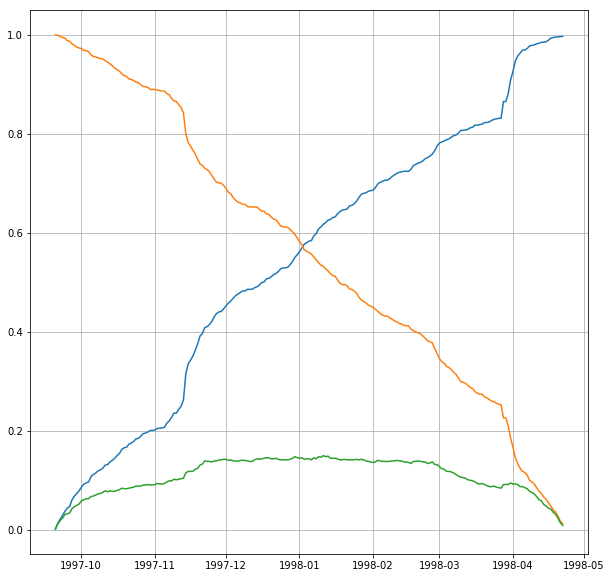

In [15]:
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(df['datetime'], df['before_user']/n_user)
plt.plot(df['datetime'], df['after_user']/n_user)
plt.plot(df['datetime'], df['inner_user']/n_user)


In [16]:
split_timestamp = 888721510
split_time = datetime.datetime.utcfromtimestamp(split_timestamp)

In [17]:
df[df.timestamp == split_timestamp]

,timestamp,datetime,before_user,before_rat,after_user,after_rat,inner_user,only_in_before,only_in_after
162,888721510,1998-03-01 03:05:10,737,78005,326,21995,120,617,206


In [9]:
# 处理user特征
u_user = pd.read_csv('ml-100k/u.user', sep='|', names=['u_id', 'age', 'gender', 'occupation', 'zip_code'])
encode = OrdinalEncoder(dtype=np.int).fit_transform(u_user[['gender', 'occupation', 'zip_code']])
u_user = pd.DataFrame(np.c_[u_user[['u_id', 'age']].values, encode],
                      columns=['u_id', 'age', 'gender', 'occupation', 'zip_code'])

u_user.head()

,u_id,age,gender,occupation,zip_code
0,1,24,1,19,622
1,2,53,0,13,689
2,3,23,1,20,270
3,4,24,1,19,331
4,5,33,0,13,133


In [22]:
u_user = pd.read_csv('ml-100k/u.user', sep='|', names=['u_id', 'age', 'gender', 'occupation', 'zip_code'])
ct = ColumnTransformer([('onehot', OrdinalEncoder(dtype=np.int), ['gender', 'occupation', 'zip_code']),
                       ('minmax', MinMaxScaler(), ['age'])], remainder='passthrough')
u_user = ct.fit_transform(u_user)
u_user = pd.DataFrame(u_user, columns=['gender', 'occupation', 'zip_code', 'age', 'u_id'])
u_user['u_id'] = u_user['u_id'].astype(np.int)
u_user['zip_code'] = u_user['zip_code'].astype(np.int)
u_user['occupation'] = u_user['occupation'].astype(np.int)
u_user['gender'] = u_user['gender'].astype(np.int)
u_user.head()

,gender,occupation,zip_code,age,u_id
0,1,19,622,0.257576,1
1,0,13,689,0.696970,2
2,1,20,270,0.242424,3
3,1,19,331,0.257576,4
4,0,13,133,0.393939,5


In [23]:
# 处理item特征
names = '''
m_id | m_title | release_date | video_release_date |
              IMDb_URL | unknown | Action | Adventure | Animation |
              Children | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western
              '''
names = [name.strip() for name in names.split('|')]
u_item = pd.read_csv('ml-100k/u.item', encoding='iso-8859-1', sep='|', names=names)
u_item.drop(['m_title', 'video_release_date', 'IMDb_URL'], axis=1, inplace=True)
u_item['release_date'].fillna(method='ffill', inplace=True)
def get_year(x):
    year_str = x[-4:]
    return int(year_str)
u_item['release_year'] = u_item['release_date'].apply(get_year)
u_item['release_year'] = (u_item['release_year'] - u_item['release_year'].min())/(u_item['release_year'].max()-u_item['release_year'].min())
u_item.drop('release_date', axis=1, inplace=True)
u_item.head()

,m_id,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.960526
1,2,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.960526
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.960526
3,4,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.960526
4,5,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0.960526


In [24]:
data_merge_user_info = data.merge(right=u_user, how='left', left_on='user', right_on='u_id')
data_merge_user_info.drop('u_id', axis=1, inplace = True)
data_merge_user_info.head()

,user,item,rating,timestamp,datetime,gender,occupation,zip_code,age
0,1,168,5,874965478,1997-09-22 21:57:58,1,19,622,0.257576
1,1,172,5,874965478,1997-09-22 21:57:58,1,19,622,0.257576
2,1,165,5,874965518,1997-09-22 21:58:38,1,19,622,0.257576
3,1,156,4,874965556,1997-09-22 21:59:16,1,19,622,0.257576
4,1,196,5,874965677,1997-09-22 22:01:17,1,19,622,0.257576


In [25]:
data_merged = data_merge_user_info.merge(right=u_item, how='left', left_on='item', right_on='m_id') 
data_merged.drop('m_id', axis=1, inplace = True)
data_merged.head()

,user,item,rating,timestamp,datetime,gender,occupation,zip_code,age,unknown,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,1,168,5,874965478,1997-09-22 21:57:58,1,19,622,0.257576,0,...,0,0,0,0,0,0,0,0,0,0.684211
1,1,172,5,874965478,1997-09-22 21:57:58,1,19,622,0.257576,0,...,0,0,0,0,1,1,0,1,0,0.763158
2,1,165,5,874965518,1997-09-22 21:58:38,1,19,622,0.257576,0,...,0,0,0,0,0,0,0,0,0,0.842105
3,1,156,4,874965556,1997-09-22 21:59:16,1,19,622,0.257576,0,...,0,0,0,0,0,0,1,0,0,0.921053
4,1,196,5,874965677,1997-09-22 22:01:17,1,19,622,0.257576,0,...,0,0,0,0,0,0,0,0,0,0.881579


In [26]:
def like(x):
    if x >3:
        return 1
    else:
        return 0
data_merged['like'] = data_merged.rating.apply(like)
data_merged.head()

,user,item,rating,timestamp,datetime,gender,occupation,zip_code,age,unknown,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,like
0,1,168,5,874965478,1997-09-22 21:57:58,1,19,622,0.257576,0,...,0,0,0,0,0,0,0,0,0.684211,1
1,1,172,5,874965478,1997-09-22 21:57:58,1,19,622,0.257576,0,...,0,0,0,1,1,0,1,0,0.763158,1
2,1,165,5,874965518,1997-09-22 21:58:38,1,19,622,0.257576,0,...,0,0,0,0,0,0,0,0,0.842105,1
3,1,156,4,874965556,1997-09-22 21:59:16,1,19,622,0.257576,0,...,0,0,0,0,0,1,0,0,0.921053,1
4,1,196,5,874965677,1997-09-22 22:01:17,1,19,622,0.257576,0,...,0,0,0,0,0,0,0,0,0.881579,1


In [27]:
data_merged.to_csv('data_merged.csv', index=False)

In [2]:

data_merged = pd.read_csv('data_merged.csv')

In [4]:
data_merged.head()

,user,item,rating,timestamp,datetime,age,gender,occupation,zip_code,unknown,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year,like
0,1,168,5,874965478,1997-09-22 21:57:58,24,1,19,622,0,...,0,0,0,0,0,0,0,0,52,1
1,1,172,5,874965478,1997-09-22 21:57:58,24,1,19,622,0,...,0,0,0,1,1,0,1,0,58,1
2,1,165,5,874965518,1997-09-22 21:58:38,24,1,19,622,0,...,0,0,0,0,0,0,0,0,64,1
3,1,156,4,874965556,1997-09-22 21:59:16,24,1,19,622,0,...,0,0,0,0,0,1,0,0,70,1
4,1,196,5,874965677,1997-09-22 22:01:17,24,1,19,622,0,...,0,0,0,0,0,0,0,0,67,1


In [3]:
split_timestamp = 888721510
split_time = datetime.datetime.utcfromtimestamp(split_timestamp)
train = data_merged[data_merged.timestamp <= split_timestamp]
y_train = train.like.values
train= train.drop(['user','item','timestamp','datetime', 'rating', 'like'], axis=1)

In [ ]:
test = data_merged[data_merged.timestamp > split_timestamp]
y_test = test.like.values
test = test.drop(['user', 'item','timestamp','datetime', 'rating', 'like'], axis=1)


In [5]:
data_merged.columns  # 每一个电影类别是一个field，不是onehot，因为一部电影会有多种类别,onehot只能有一个非零

Index(['user', 'item', 'rating', 'timestamp', 'datetime', 'age', 'gender',
       'occupation', 'zip_code', 'unknown', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'release_year', 'like'],
      dtype='object')

#### fm用onehot处理 deepfm用embedding处理，方式不同，但处理结果是相同的，
#### embedding_lookup取出的是值为1的feature，值为0的丢弃，onehot后矩阵相乘，同样不会计算值为0
#### 在电影类别中（‘unknown', 'Action',etc）0,1为分类，不是上述的值为0或1，，如电影在unknown这个field为0，
#### 那么说明此电影其属于"0"这个分类，这个分类值为1，"1"这个分类值为0，在look_up时，的确没有计算“1”这个分类 
#### 明确'unknown', 'Action', 'Adventure', 'Animation',这些都是field，0,1是这个field的两个分类。